In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train_labels.csv', 'train_images.pkl', 'test_images.pkl']


In [11]:
#Files are stored in pickle format.
#Load them like how you load any pickle. The data is a numpy array
import pandas as pd
train_images = pd.read_pickle('../input/train_images.pkl')
train_labels = pd.read_csv('../input/train_labels.csv')

In [12]:
train_images.shape

(40000, 64, 64)

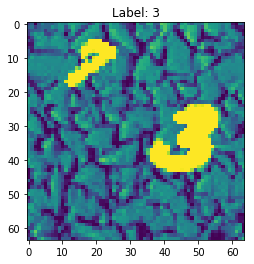

In [13]:
import matplotlib.pyplot as plt

#Let's show image with id 16
img_idx = 200

plt.title('Label: {}'.format(train_labels.iloc[img_idx]['Category']))
plt.imshow(train_images[img_idx])
plt.show()

# Imports

In [14]:
import csv

import matplotlib.patches as mpatches

from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
from skimage.segmentation import clear_border

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

# Preprocessing

In [15]:
def preprocess(x, imgDim, labels):
    finalData = np.zeros(shape=(x.shape[0], imgDim, imgDim))
    finImgs = np.zeros(shape=(x.shape[0] * 4, imgDim, imgDim))
    finLabels = []
    #Loop through every image in provided data
    for n in range(x.shape[0]):

        #Binarizing the image
        currImg = np.array(x[n])
        currImg[currImg != 255] = 0 #Non-black pixel--> threshold as a 0.
        currImg[currImg == 255] = 1 #255 intensity --> threshold as a 1.
        binarizedImg = currImg # >= thresh
        labelledCompImg = label(binarizedImg)  #Labels each connected component in binarized image

        biggestRegion = regionprops(labelledCompImg) #initialize current maximum connected component
        prevLen = 0
        #For every connected component, check if it's the biggest in the image.
        for region in regionprops(labelledCompImg):
            minRow, minCol, maxRow, maxCol = region.bbox #find bounding box
            length = max(abs(minRow-maxRow), abs(minCol-maxCol))
            if length > prevLen: #compare length of bounding boxes in img
                prevLen = length
                biggestRegion = region

        #Isolate the largest component by cropping it's bounding box
        minRow, minCol, maxRow, maxCol = biggestRegion['BoundingBox']
        isolatedNum = binarizedImg[min(minRow,maxRow):max(minRow,maxRow), min(minCol,maxCol):max(minCol,maxCol)]
        
        #Transform to new dimensions 28x28
        finalData[n] = resize(isolatedNum, (imgDim,imgDim))
        
        #Rotate and copy the data 4 times, duplicate the labels 4 times
        for i in range(4):
            idx = 4 * n + i
            finImgs[idx] = rotate(finalData[n], 90 * i)
            finLabels.append(labels[n])

        if (n%2000 == 0):
            print("Currently on example #: ", n)
            
    return finImgs, finLabels

# Data Splitting & Encoding

In [18]:
#Read labels and store them
yTrain = []
with open("../input/train_labels.csv", "r") as csv_file: #Because this was quicker than Panda
    csv_reader = csv.reader(csv_file, delimiter=',')
    for lines in csv_reader:
        yTrain.append(lines[1])
yTrain.remove('Category')

In [19]:
#Run the data through the preprocessor 
xTrain, yTrain = preprocess(train_images[0:1000], 28, yTrain[0:1000]) #[0:1000] is just for quick testing, remove for whole training.

Currently on example #:  0


In [20]:
#Validation split 
x_train, x_valid, y_train, y_valid = train_test_split(xTrain, yTrain, test_size=0.2)

(4000, 28, 28)
4000
3


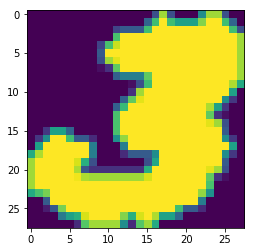

In [21]:
#Testing 
print(xTrain.shape)
print(len(yTrain))
plt.imshow(xTrain[img_idx*4])
print(yTrain[img_idx*4])

In [22]:
#Reshape for encoding.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)

#One-hot encoding
number_of_classes = 10
y_train = np.array(np_utils.to_categorical(y_train, number_of_classes))
y_valid = np.array(np_utils.to_categorical(y_valid, number_of_classes))

# Example #1 from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [23]:
model = Sequential()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

gen = ImageDataGenerator(    width_shift_range = 0.075,
    height_shift_range = 0.075,
    rotation_range = 12,
    shear_range = 0.075,
    zoom_range = 0.05,
    fill_mode = 'constant',
    cval = 0)

test_gen = ImageDataGenerator()

print(x_train.shape)
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_valid, y_valid, batch_size=64)

model.fit_generator(train_generator, steps_per_epoch=50000//64, epochs=1, #epochs should be 2
                    validation_data=test_generator, validation_steps=10000//64)

score = model.evaluate(x_valid, y_valid)
print()
print('Validation accuracy: ', score[1])

(3200, 28, 28, 1)
Epoch 1/1
800/800 [==============================] - 1s 1ms/step

Validation accuracy:  0.7475


In [18]:
print('Validation accuracy: ', score[0])

IndexError: list index out of range

# Example 2

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

gen = ImageDataGenerator(    width_shift_range = 0.075,
    height_shift_range = 0.075,
    rotation_range = 12,
    shear_range = 0.075,
    zoom_range = 0.05,
    fill_mode = 'constant',
    cval = 0)

test_gen = ImageDataGenerator()


print(x_train.shape)
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_valid, y_valid, batch_size=64)

model.fit_generator(train_generator, steps_per_epoch=50000//64, epochs=2, 
                    validation_data=test_generator, validation_steps=10000//64)

score = model.evaluate(x_valid, y_valid)
print()
print('Validation accuracy: ', score[1])

(800, 28, 28, 1)
Epoch 1/2
781/781 [==============================] - 309s 396ms/step - loss: 0.1750 - acc: 0.9475 - val_loss: 0.7170 - val_acc: 0.8744
Epoch 2/2
199/199 [==============================] - 0s 2ms/step

Validation accuracy:  0.8291457286432161
